In [137]:
import numpy as np # Deals with array
import pandas as pd # Deals with data
import torch # Pytorch lib
import torch.nn as nn # Neural net lib
from torch.autograd import Variable # Deals with mathematical functions like differentiation, etc
import yfinance as yf # Yahoo finance api to get historical financial data
import matplotlib.pyplot as plt # Used to plot graphs
from matplotlib import style # plt.style.available
import mplfinance as mpl # Used to plot graph of financial data
from sklearn.model_selection import train_test_split # Used to split data into training and testing one
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Used for preprocessing of data
import torch.utils.data as data

In [138]:
df= yf.download('ETH-USD')

[*********************100%%**********************]  1 of 1 completed


In [139]:
# Splitting the data into testing data and training data
train_size = int(len(df) * 0.90) # first 90% 
test_size = len(df) - train_size # last 10%
train, test = df[:train_size], df[train_size:]

print("Entire dataset shape:", df.shape)
print("Training dataset shape:", train.shape)
print("Testing dataset shape:", test.shape)

Entire dataset shape: (2239, 6)
Training dataset shape: (2015, 6)
Testing dataset shape: (224, 6)


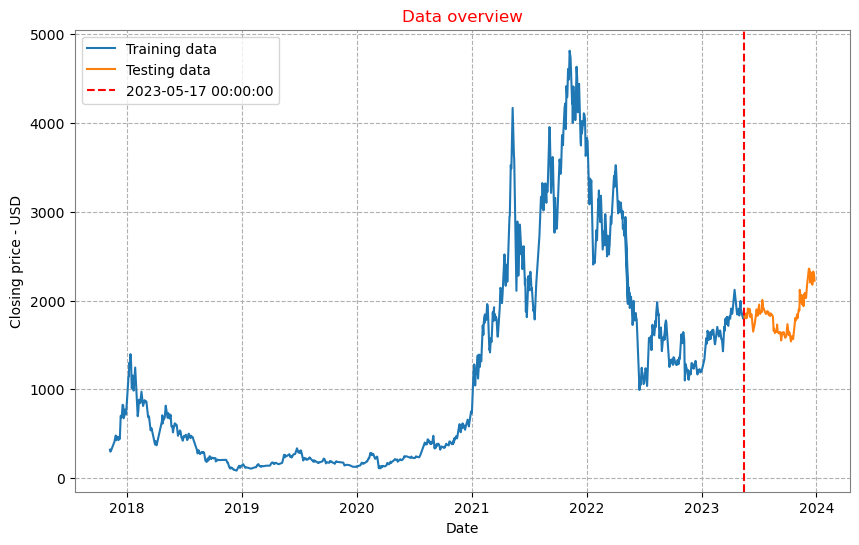

In [140]:
plt.figure(figsize=(10,6))
plt.plot(train.index, train['Close'], label='Training data')
plt.plot(test.index, test['Close'], label='Testing data')
plt.axvline(x=test.index[0], c='r', label=test.index[0], linestyle='--')
plt.title('Data overview')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Closing price - USD')
plt.show()

In [142]:
# This function is combined with dataloader to applies windows effect on the time series dataset.

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature_data = dataset[i:i+lookback] # n days will be features
        target_data = dataset[i+lookback:i+lookback+1] # n+1 th day will be target
        feature = np.array(feature_data).astype('float32')
        target = np.array(target_data['Close']).astype('float32')
        X.append(feature)
        y.append(target)
        
    return torch.tensor(X), torch.tensor(y)

In [143]:
# This is the model itself

class CryptoModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(CryptoModel, self).__init__()
        self.input_size = input_size #storing inputs
        self.hidden_size = hidden_size
        self.output_size = output_size 
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(input_size, hidden_size) # Defining the layers of the model
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        h = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        output, (h, c) = self.lstm(x, (h, c)) # I might be doing something wrong in this line
        hn = h.view(-1, self.hidden_size) # Or in this line :(
        out = self.relu(hn) # Dataflow through the layers of the model
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [150]:
# Instantiating the model

input_size = 6 # number of features to input
hidden_size = 6 # number of hidden layers
output_size = 1 # number feature will be output
num_layers = 1 # number of stacked lstm layers

model = CryptoModel(input_size, hidden_size, output_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer

# Futher splitting the data using create_dataset
window=7
X_train, y_train = create_dataset(train, window)
X_test, y_test = create_dataset(test, window)

# This dataloader slices a sample of the 'window size' from the data. 
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=64)

In [154]:
# Training the model on 1000 epochs

n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
        
    #I have no idea what is happening below this line (in this cell)
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(criterion(y_pred, y_train))
    print("Epoch %d: train RMSE %.4f" % (epoch, train_rmse))

Epoch 0: train RMSE 1171.6118
Epoch 100: train RMSE 1164.6516
Epoch 200: train RMSE 1160.9734
Epoch 300: train RMSE 1159.1042
Epoch 400: train RMSE 1158.1909
Epoch 500: train RMSE 1157.7653
Epoch 600: train RMSE 1157.5806
Epoch 700: train RMSE 1157.5107
Epoch 800: train RMSE 1157.4927
Epoch 900: train RMSE 1157.4961


In [155]:
# Peeking into the predictions made on training data

loop=0
for X_batch, y_batch in loader:
    train_pred = model(X_batch)
    #print("Prediction value :", y_pred)
    loop = loop+1
    if(loop<=2):
        print('Predictions on training data:', train_pred[0])

Predictions on training data: tensor([1176.5398], grad_fn=<SelectBackward0>)
Predictions on training data: tensor([1176.5398], grad_fn=<SelectBackward0>)


In [156]:
# Looking at the predictions made on testing data

test_pred = model(X_test)
loss = criterion(test_pred, y_test)
print('Predictions on testing data:', test_pred[0])

# Problem: train_pred and test_pred are 100% same!

Predictions on testing data: tensor([1176.5398], grad_fn=<SelectBackward0>)
